In [1]:
import anndata as ad
import scanpy as sc
from sklearn.metrics import adjusted_rand_score

# specify the directory where data are stored
DATADIR = ''

# specify the directory where data and metadata are stored
METADATADIR = '../../input/'

### metrics

In [2]:
adatareduced = ad.read('processed_beunrostro.h5ad')

In [7]:
# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

In [3]:
# metrics on the default louvain clustering
labels_true = adatareduced.obs['cell_type']
labels_pred = adatareduced.obs['louvain']
print(adjusted_rand_score(labels_true, labels_pred))

0.5595800452296648


step 0
got 16 at resolution 1.5
step 1
got 10 at resolution 0.75


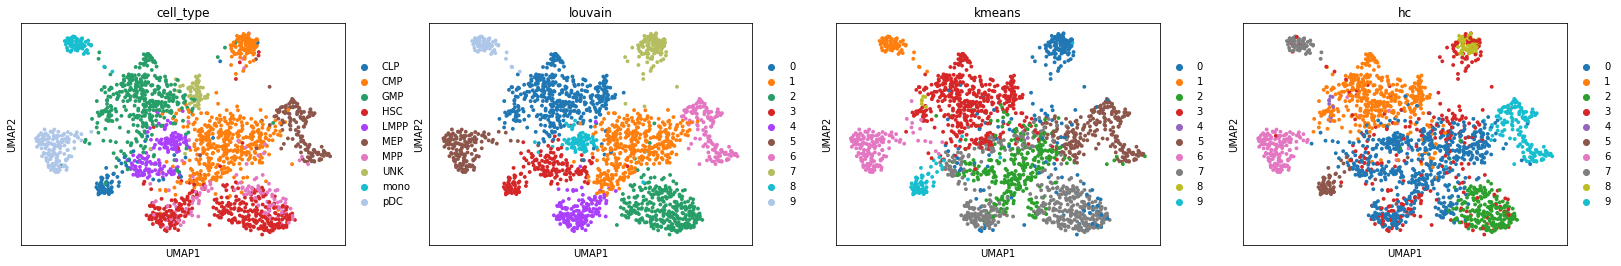

In [4]:
############ Benchmarking ############

import pandas as pd
import numpy as np
import scanpy as sc
import os
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import homogeneity_score
import seaborn as sns


def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        print('step ' + str(this_step))
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        
        print('got ' + str(this_clusters) + ' at resolution ' + str(this_resolution))
        
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    
    print('Cannot find the number of clusters')
    print('Clustering solution from last iteration is used:' + str(this_clusters) + ' at resolution ' + str(this_resolution))
    
    
    
df_metrics = pd.DataFrame(columns=['ARI_Louvain','ARI_kmeans','ARI_HC',
                                   'AMI_Louvain','AMI_kmeans','AMI_HC',
                                   'Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC'])


# set method name
method = 'epiScanpy'

# convert the cell label to standard label
adatareduced.obs['label'] = adatareduced.obs['cell_type']

# set the number of cluster for louvain
num_clusters = len(np.unique(adatareduced.obs['label']))
#print(num_clusters)

# set the epiScanpy metric raw in the pandas dataframe
df_metrics.loc[method,] = ""

## get the clusters

#Louvain
#sc.pp.neighbors(adata, n_neighbors=15,use_rep='X') # I MUST NOT recalculate the neighboring graph like this
#sc.tl.louvain(adata)
getNClusters(adatareduced,n_cluster=num_clusters)

#kmeans
#kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adata.X)
kmeans = KMeans(n_clusters=num_clusters, random_state=2019).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['kmeans'] = pd.Series(kmeans.labels_,index=adatareduced.obs.index).astype('category')

#hierachical clustering
#hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adata.X)
hc = AgglomerativeClustering(n_clusters=num_clusters).fit(adatareduced.obsm['X_pca'])
adatareduced.obs['hc'] = pd.Series(hc.labels_,index=adatareduced.obs.index).astype('category')

#adjusted rank index
ari_louvain = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['louvain'])
ari_kmeans = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['kmeans'])
ari_hc = adjusted_rand_score(adatareduced.obs['label'], adatareduced.obs['hc'])
#adjusted mutual information
ami_louvain = adjusted_mutual_info_score(adatareduced.obs['label'], adatareduced.obs['louvain'],average_method='arithmetic')
ami_kmeans = adjusted_mutual_info_score(adatareduced.obs['label'], adatareduced.obs['kmeans'],average_method='arithmetic')   
ami_hc = adjusted_mutual_info_score(adatareduced.obs['label'], adatareduced.obs['hc'],average_method='arithmetic')
#homogeneity
homo_louvain = homogeneity_score(adatareduced.obs['label'], adatareduced.obs['louvain'])
homo_kmeans = homogeneity_score(adatareduced.obs['label'], adatareduced.obs['kmeans'])
homo_hc = homogeneity_score(adatareduced.obs['label'], adatareduced.obs['hc'])

df_metrics.loc[method,['ARI_Louvain','ARI_kmeans','ARI_HC']] = [ari_louvain,ari_kmeans,ari_hc]
df_metrics.loc[method,['AMI_Louvain','AMI_kmeans','AMI_HC']] = [ami_louvain,ami_kmeans,ami_hc]
df_metrics.loc[method,['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = [homo_louvain,homo_kmeans,homo_hc] 
#adata.obs[['louvain','kmeans','hc']].to_csv(os.path.join(path_clusters ,method + '_clusters.tsv'),sep='\t')

sc.pl.umap(adatareduced, color=['cell_type', 'louvain', 'kmeans', 'hc'])


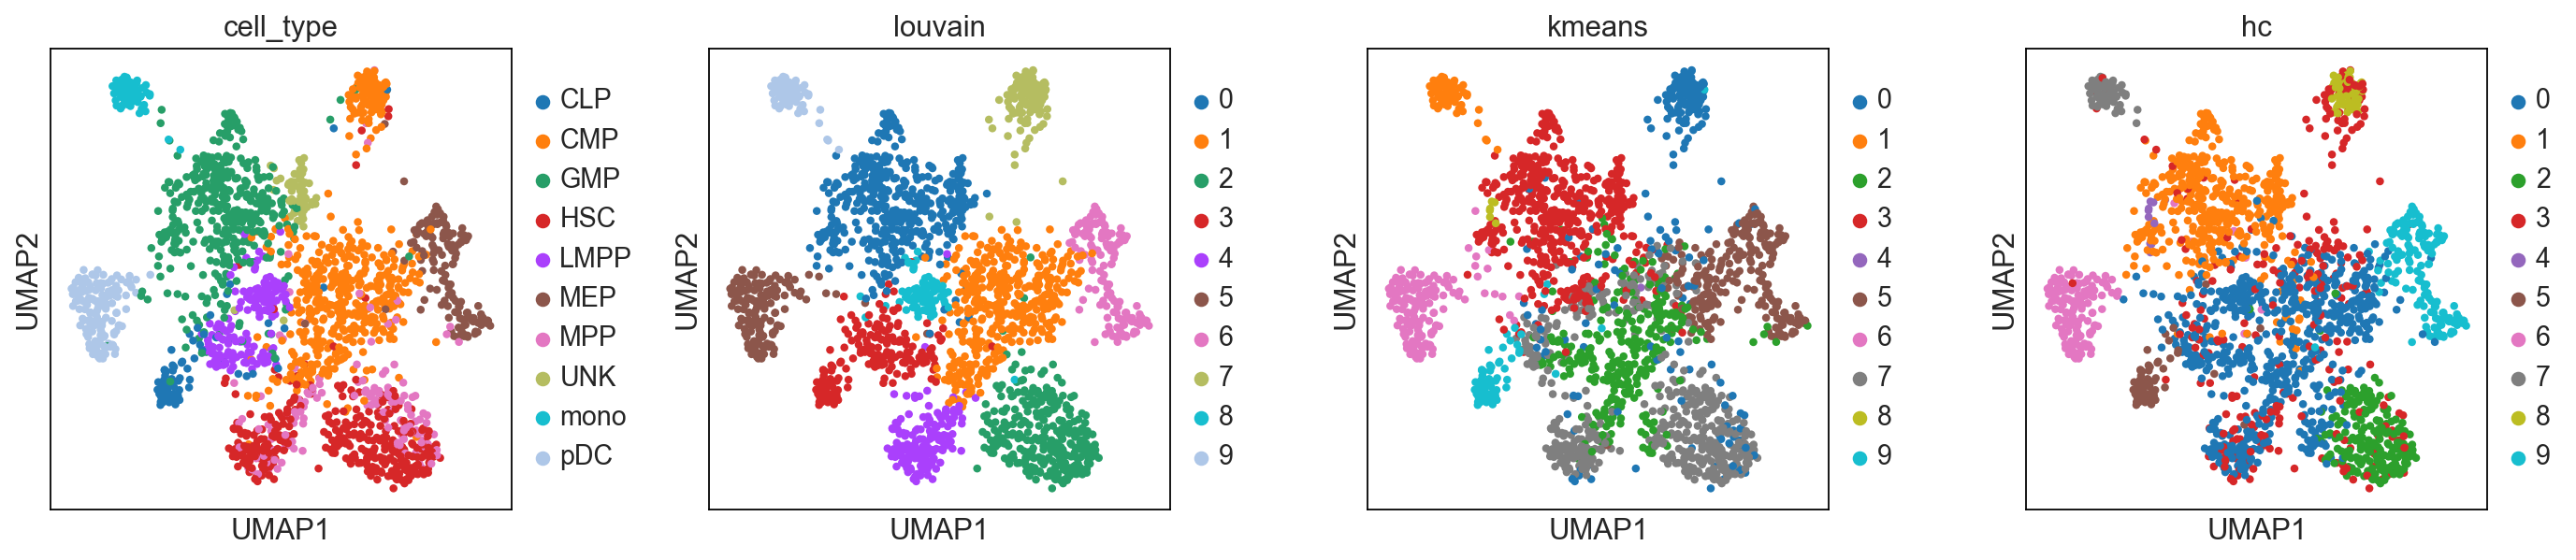

In [10]:
sc.pl.umap(adatareduced, color=['cell_type', 'louvain', 'kmeans', 'hc'], wspace=0.3)

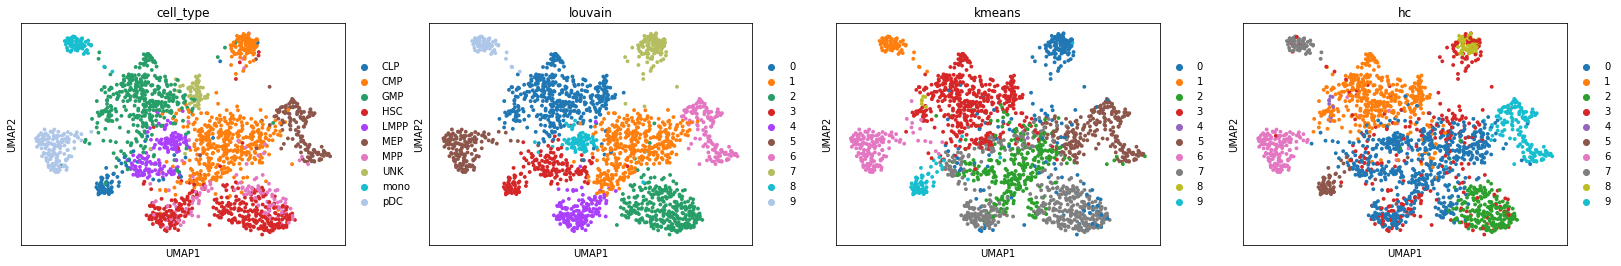

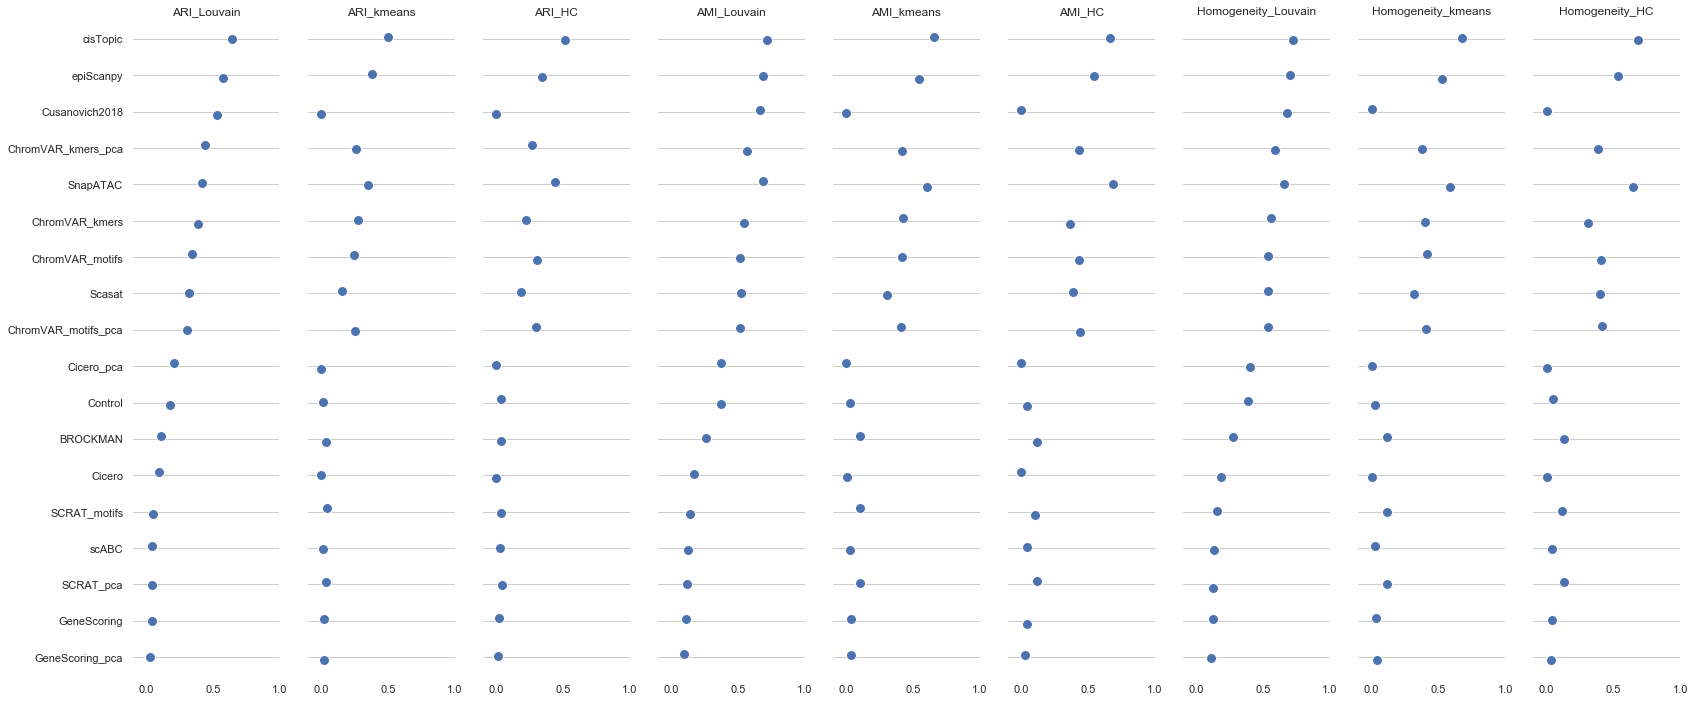

In [5]:
all_metrics = """ARI_Louvain	ARI_kmeans	ARI_HC	AMI_Louvain	AMI_kmeans	AMI_HC	Homogeneity_Louvain	Homogeneity_kmeans	Homogeneity_HC
ChromVAR_motifs	0.344884	0.243458	0.307777	0.516044	0.415984	0.432023	0.53329	0.414872	0.407445
ChromVAR_kmers	0.389598	0.279133	0.221587	0.544125	0.428086	0.362537	0.555826	0.400741	0.307758
cisTopic	0.641239	0.498477	0.51701	0.719416	0.657523	0.661236	0.7252	0.681288	0.682697
SnapATAC	0.420341	0.353299	0.443056	0.684499	0.605017	0.689081	0.652815	0.589645	0.645974
SCRAT_motifs	0.0515874	0.040599	0.0380492	0.140008	0.101852	0.104561	0.154075	0.115026	0.116999
BROCKMAN	0.115213	0.0329884	0.0353507	0.261593	0.103987	0.119018	0.274468	0.115736	0.131517
Cusanovich2018	0.533643	-0.00194164	-0.00194164	0.663841	-0.00278841	-0.00278841	0.680403	0.00302188	0.00302188
Control	0.182422	0.0137586	0.0344167	0.372463	0.024063	0.0449997	0.384145	0.0242291	0.044414
GeneScoring	0.0417257	0.0208223	0.0244348	0.112021	0.0315973	0.0401868	0.121847	0.0349462	0.0413666
Scasat	0.320218	0.1597	0.18861	0.519518	0.300951	0.383886	0.538066	0.32015	0.397076
scABC	0.0450337	0.0127084	0.0248051	0.12754	0.0239257	0.0433246	0.132366	0.024874	0.043172
Cicero	0.09669	-0.00325062	-0.00215327	0.172726	0.00262284	-0.00253554	0.180195	0.00641933	0.00335946
ChromVAR_kmers_pca	0.443234	0.262985	0.270338	0.56954	0.420358	0.434644	0.590846	0.377882	0.386469
ChromVAR_motifs_pca	0.308443	0.256185	0.294866	0.516459	0.410229	0.43911	0.534353	0.407546	0.412825
GeneScoring_pca	0.0306601	0.024873	0.0135162	0.0951604	0.0362062	0.0298817	0.107238	0.0395731	0.0322586
Cicero_pca	0.211067	-0.00194164	-0.00215327	0.37366	-0.00278841	-0.00253554	0.397431	0.00302188	0.00335946
SCRAT_pca	0.0441418	0.0392368	0.0433118	0.114929	0.0989591	0.115728	0.126979	0.112535	0.129509
"""

all_metrics = [line.split('\t') for line in  all_metrics.split('\n')[:-1]]

for line in all_metrics[1:]:
    df_metrics.loc[line[0],['ARI_Louvain','ARI_kmeans','ARI_HC']] = line[1:4]
    df_metrics.loc[line[0],['AMI_Louvain','AMI_kmeans','AMI_HC']] = line[4:7]
    df_metrics.loc[line[0],['Homogeneity_Louvain','Homogeneity_kmeans','Homogeneity_HC']] = line[7:]

sc.pl.umap(adatareduced, color=['cell_type', 'louvain', 'kmeans', 'hc'])


for key in df_metrics.keys():
    df_metrics[key] = [float(key) for key in df_metrics[key]]
    
df_metrics['method'] = df_metrics.index.tolist()


sns.set(style="whitegrid")

# data to plot
#df_metrics

# Make the PairGrid
g = sns.PairGrid(df_metrics.sort_values("ARI_Louvain", ascending=False),
                 x_vars=df_metrics.columns[:9], y_vars=["method"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      #palette="ch:s=1,r=-.1,h=1_r",
      linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.1, 1.), xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ['ARI_Louvain', 'ARI_kmeans', 'ARI_HC',
          'AMI_Louvain', 'AMI_kmeans', 'AMI_HC',
          'Homogeneity_Louvain', 'Homogeneity_kmeans', 'Homogeneity_HC']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [6]:
df_metrics

,ARI_Louvain,ARI_kmeans,ARI_HC,AMI_Louvain,AMI_kmeans,AMI_HC,Homogeneity_Louvain,Homogeneity_kmeans,Homogeneity_HC,method
epiScanpy,0.578401,0.381892,0.340018,0.685722,0.541741,0.546233,0.700935,0.526021,0.532408,epiScanpy
ChromVAR_motifs,0.344884,0.243458,0.307777,0.516044,0.415984,0.432023,0.533290,0.414872,0.407445,ChromVAR_motifs
ChromVAR_kmers,0.389598,0.279133,0.221587,0.544125,0.428086,0.362537,0.555826,0.400741,0.307758,ChromVAR_kmers
cisTopic,0.641239,0.498477,0.517010,0.719416,0.657523,0.661236,0.725200,0.681288,0.682697,cisTopic
SnapATAC,0.420341,0.353299,0.443056,0.684499,0.605017,0.689081,0.652815,0.589645,0.645974,SnapATAC
SCRAT_motifs,0.051587,0.040599,0.038049,0.140008,0.101852,0.104561,0.154075,0.115026,0.116999,SCRAT_motifs
BROCKMAN,0.115213,0.032988,0.035351,0.261593,0.103987,0.119018,0.274468,0.115736,0.131517,BROCKMAN
Cusanovich2018,0.533643,-0.001942,-0.001942,0.663841,-0.002788,-0.002788,0.680403,0.003022,0.003022,Cusanovich2018
Control,0.182422,0.013759,0.034417,0.372463,0.024063,0.045000,0.384145,0.024229,0.044414,Control
GeneScoring,0.041726,0.020822,0.024435,0.112021,0.031597,0.040187,0.121847,0.034946,0.041367,GeneScoring
